In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,f1_score,accuracy_score
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRFClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf

import nltk
import gensim

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve,f1_score,accuracy_score
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,XGBRFClassifier

import tensorflow as tf

import nltk
import gensim

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load cleaned dataset
#df = pd.read_csv('/kaggle/input/twitterdata/tweets-engagement-metrics.csv')
df = pd.read_csv(r"Clean data.csv")

# Display the first 5 entries of the DataFrame
df.head(5)

,Unnamed: 0,clean_text_processed,Mood
0,0,"['adrianrusso', 'innovation', 'lab', 'official...",0
1,1,"['open', 'aws', 'asia', 'pacific', 'seoul', 'r...",0
2,2,"['beginner', 'guide', 'scaling', 'million', 'u...",0
3,3,"['bridging', 'aws', 'azure', 'environment', 'v...",0
4,4,"['elk', 'aws', 'elasticsearch', 'service', 'el...",0


In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
mood_counts = df['Mood'].value_counts()
mood_counts

Mood
 0    64209
 1    26507
-1     5292
Name: count, dtype: int64

In [60]:
df[['clean_text_processed', 'Mood']].head(5)

,clean_text_processed,Mood
0,"['adrianrusso', 'innovation', 'lab', 'official...",0
1,"['open', 'aws', 'asia', 'pacific', 'seoul', 'r...",0
2,"['beginner', 'guide', 'scaling', 'million', 'u...",0
3,"['bridging', 'aws', 'azure', 'environment', 'v...",0
4,"['elk', 'aws', 'elasticsearch', 'service', 'el...",0


In [61]:
# Create a mapping dictionary
mood_mapping = {
    -1: 'Negative',
    0: 'Neutral',
    1: 'Positive'
}

# Apply the mapping to the 'Mood' column
df['Mood'] = df['Mood'].map(mood_mapping)

# Display the DataFrame to check the changes
print(df.head())

                                clean_text_processed     Mood
0  ['adrianrusso', 'innovation', 'lab', 'official...  Neutral
1  ['open', 'aws', 'asia', 'pacific', 'seoul', 'r...  Neutral
2  ['beginner', 'guide', 'scaling', 'million', 'u...  Neutral
3  ['bridging', 'aws', 'azure', 'environment', 'v...  Neutral
4  ['elk', 'aws', 'elasticsearch', 'service', 'el...  Neutral


In [62]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text_processed'], df['Mood'], test_size = 0.2, random_state = 0)

In [9]:
print('the shape of X_train and  y_train: ', len(X_train), y_train.shape)
print('the shape of X_test and  y_test: ', len(X_test),y_test.shape)

the shape of X_train and  y_train:  76806 (76806,)
the shape of X_test and  y_test:  19202 (19202,)


Prepare Document term matrix using TfIdf

In [63]:
vectorizer = TfidfVectorizer(max_features = 40000)

# Model fitting
X_train_ds =vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

X_train_bow.shape, X_test_bow.shape

((76806, 36702), (19202, 36702))

Model building and testing using multinomial Naive Bayes classifier

In [64]:
# Model building using multinomial Naive Bayes classifier
model_MNB = MultinomialNB()
model_MNB.fit(X_train_bow, y_train)  # Use the sparse matrix directly

# Get Train and Test Accuracy Score
train_score = model_MNB.score(X_train_bow, y_train)
test_score = model_MNB.score(X_test_bow, y_test)

print(f'Train Accuracy: {train_score}')
print(f'Test Accuracy: {test_score}')
print()

# Get precision recall and f1-score
cr=classification_report(y_true=y_train,y_pred=model_MNB.predict( X_train_bow))
print('classification_report TRAIN Data\n',cr)

# Get precision recall and f1-score
cr=classification_report(y_true=y_test,y_pred=model_MNB.predict( X_test_bow ))
print('classification_report TEST Data\n',cr)

Train Accuracy: 0.8657005963075801
Test Accuracy: 0.8259035517133632

classification_report TRAIN Data
               precision    recall  f1-score   support

    Negative       0.96      0.26      0.41      4187
     Neutral       0.85      0.98      0.91     51396
    Positive       0.91      0.70      0.79     21223

    accuracy                           0.87     76806
   macro avg       0.91      0.65      0.70     76806
weighted avg       0.87      0.87      0.85     76806

classification_report TEST Data
               precision    recall  f1-score   support

    Negative       0.97      0.20      0.33      1105
     Neutral       0.82      0.97      0.89     12813
    Positive       0.86      0.60      0.71      5284

    accuracy                           0.83     19202
   macro avg       0.88      0.59      0.64     19202
weighted avg       0.84      0.83      0.81     19202



The model struggles with the negative sentiment class, with a low recall indicating many false negatives.

In [65]:
# Prediction
test_ds_predicted = model_MNB.predict( X_test_bow.toarray() )
test_ds_predicted[0:50]

# Majority is  predicted as neutral because of the class imbalance
# -1 = negative
# 0 = neutral
# 1 = positive

array(['Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'Positive', 'Positive', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Neutral'], dtype='<U8')

Tackling Class Imbalance Problem
- To address class imbalance, you can use oversampling or undersampling techniques.
- When dealing with imbalanced classes, evaluate model performance using metrics such as precision, recall, F1-score, and the AUC-ROC curve. For this project, use the F1-score as the primary evaluation criterion.
- Consider using tree-based classifiers like Random Forest and XGBoost.

Over sampling approach

length of X_train_bow and y_train before Oversampling 76806 76806
length of X_test_bow and y_test before Oversampling 19202 19202
length of X_train_bow and y_train after Oversampling 154188 154188
length of X_test_bow and y_test after Oversampling 38439 38439


<Axes: xlabel='Mood', ylabel='count'>

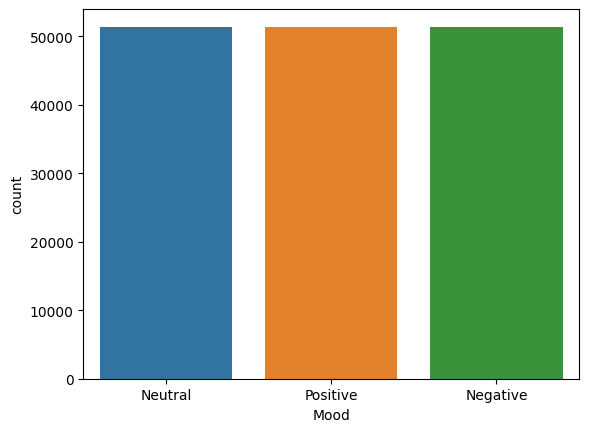

In [66]:
from imblearn.over_sampling import SMOTE

print('length of X_train_bow and y_train before Oversampling',X_train_bow.shape[0],len(y_train))
print('length of X_test_bow and y_test before Oversampling',X_test_bow.shape[0],len(y_test))

OS=SMOTE(random_state=42)
X_train_bow_OS,y_train_OS=OS.fit_resample(X_train_bow,y_train)
X_test_bow_OS,y_test_OS=OS.fit_resample(X_test_bow,y_test)

print('length of X_train_bow and y_train after Oversampling',X_train_bow_OS.shape[0],len(y_train_OS))
print('length of X_test_bow and y_test after Oversampling',X_test_bow_OS.shape[0],len(y_test_OS))

# Check for data balance
sns.countplot(x=y_train_OS)

For under sampling approach

length of X_train_bow and y_train before Undersampling 76806 76806
length of X_test_bow and y_test before Undersampling 19202 19202
length of X_train_bow and y_train after Undersampling 12561 12561
length of X_test_bow and y_test after Undersampling 3315 3315


<Axes: xlabel='Mood', ylabel='count'>

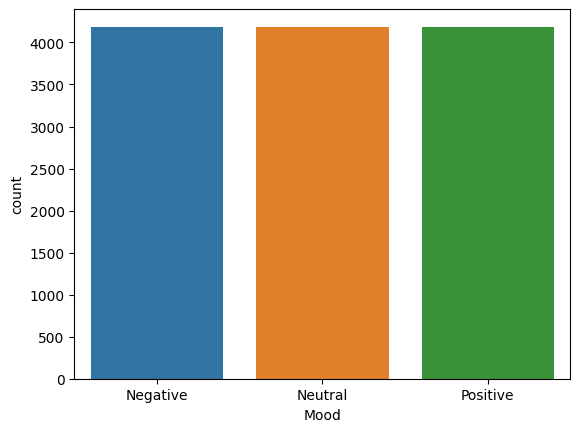

In [67]:
from imblearn.under_sampling import RandomUnderSampler,NearMiss

print('length of X_train_bow and y_train before Undersampling',X_train_bow.shape[0],len(y_train))
print('length of X_test_bow and y_test before Undersampling',X_test_bow.shape[0],len(y_test))

US=NearMiss()
X_train_bow_US,y_train_US=US.fit_resample(X_train_bow,y_train)
X_test_bow_US,y_test_US=US.fit_resample(X_test_bow,y_test)

print('length of X_train_bow and y_train after Undersampling',X_train_bow_US.shape[0],len(y_train_US))
print('length of X_test_bow and y_test after Undersampling',X_test_bow_US.shape[0],len(y_test_US))

# Check for data balance
sns.countplot(x=y_train_US)

### Use of multinomial Naive Bayes classifier with Oversampling data

In [68]:
%%time
# Model building using multinomial Naive Bayes classifier
model_MNB_OS = MultinomialNB()
model_MNB_OS.fit( X_train_bow_OS,y_train_OS)

#Get Train and Test Accuracy Score
train_score=model_MNB_OS.score(X_train_bow_OS,y_train_OS)
test_score=model_MNB_OS.score(X_test_bow_OS,y_test_OS)

print('train score is:{} '.format(train_score))
print('test score is:{} '.format(test_score))
print() 

#Get precision    recall  and f1-score on Train data
cr=classification_report(y_true=y_train_OS,y_pred=model_MNB_OS.predict( X_train_bow_OS))
print('classification_report TRAIN Data\n',cr)

#Get precision    recall  and f1-score on Test data
cr=classification_report(y_true=y_test_OS,y_pred=model_MNB_OS.predict( X_test_bow_OS ))
print('classification_report TEST Data\n',cr)

train score is:0.9097076296469245 
test score is:0.847888862873644 

classification_report TRAIN Data
               precision    recall  f1-score   support

    Negative       0.90      0.98      0.94     51396
     Neutral       0.94      0.83      0.88     51396
    Positive       0.89      0.92      0.90     51396

    accuracy                           0.91    154188
   macro avg       0.91      0.91      0.91    154188
weighted avg       0.91      0.91      0.91    154188

classification_report TEST Data
               precision    recall  f1-score   support

    Negative       0.87      0.89      0.88     12813
     Neutral       0.87      0.78      0.83     12813
    Positive       0.81      0.87      0.84     12813

    accuracy                           0.85     38439
   macro avg       0.85      0.85      0.85     38439
weighted avg       0.85      0.85      0.85     38439

CPU times: total: 3.25 s
Wall time: 5.04 s


In [69]:
# Prediction
test_ds_predicted = model_MNB_OS.predict( X_test_bow_OS)
test_ds_predicted[0:50]

array(['Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Positive', 'Negative',
       'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral',
       'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Positive', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral'], dtype='<U8')

ROC and AUC score - Multi-Class Classification
- Since this is a multi-class classification problem, we need to ensure our labels adhere to binary classification logic.
- To achieve this, we can use the OneVsRestClassifier.
- Requirements for the OneVsRestClassifier include: Labels must be numeric, model algorithm must support either predict_proba or decision_function.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=40000, stop_words='english')

# Convert text data into numerical features
X = tfidf.fit_transform(df['clean_text_processed'])

# Ensure y is a 1D array of labels
y = df['Mood'].values

# Initialize SMOTE
smote = SMOTE(random_state=777, k_neighbors=1)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X, y)

#Lets first encode our labels
from sklearn.preprocessing import label_binarize

y_train_lb = label_binarize(y_train_OS, classes=['Negative','Neutral','Positive'])
y_test_lb = label_binarize(y_test_OS, classes=['Negative','Neutral','Positive'])

n_classes = y_train_lb.shape[1]

# Create NaiveBayes OneVsRestClassifier Model
from sklearn.multiclass import OneVsRestClassifier

multiClassModel = OneVsRestClassifier(MultinomialNB())
y_score = multiClassModel.fit(X_train_bow_OS,y_train_lb).predict_proba(X_test_bow_OS)


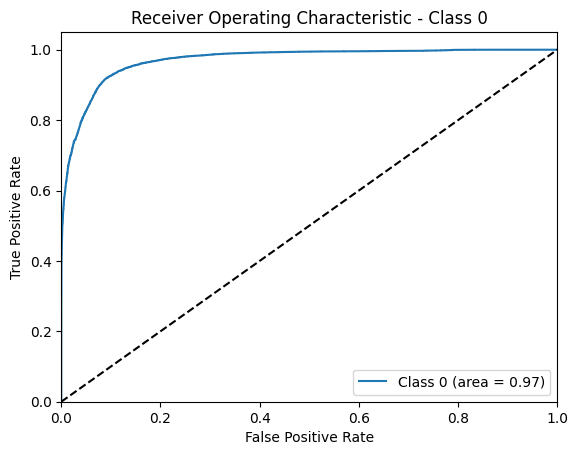

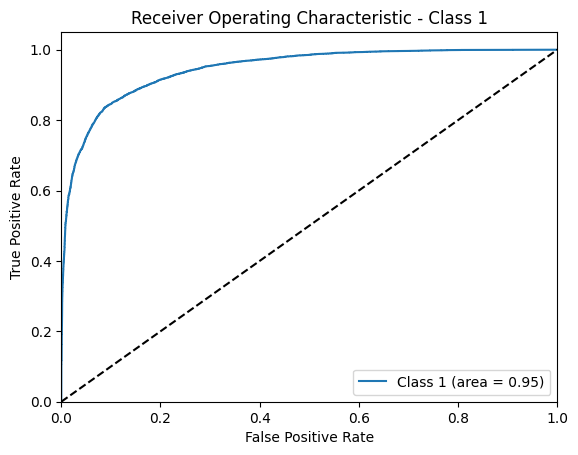

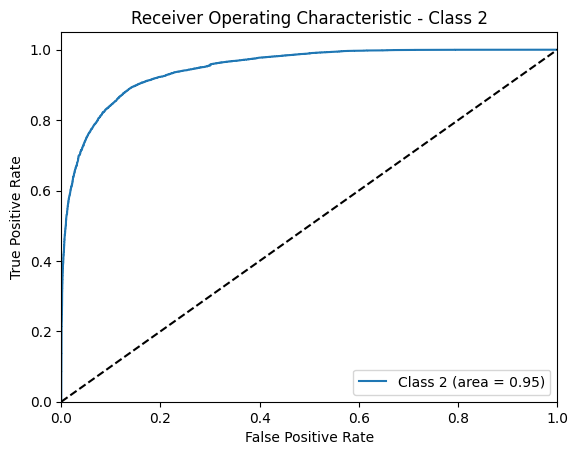

In [71]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test_lb is the label-binarized version of y_test
# and y_score is the prediction scores for each class
n_classes = y_test_lb.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if len(np.unique(y_test_lb[:, i])) == 1:
        print(f"Skipping class {i} as it has only one class present in y_true.")
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_lb[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_lb[:, i], y_score[:, i])

# Plot ROC curves for each class
for i in range(n_classes):
    if i in fpr:
        plt.figure()
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Class {i}')
        plt.legend(loc="lower right")
        plt.show()


### Use of multinomial Naive Bayes classifier with Undersampling Data

In [73]:
# Model building using multinomial Naive Bayes classifier
model_MNB = MultinomialNB()
model_MNB.fit( X_train_bow_US.toarray(),y_train_US)

# Get Train and Test Accuracy Score
train_score=model_MNB.score(X_train_bow_US.toarray(),y_train_US)
test_score=model_MNB.score(X_test_bow_US.toarray(),y_test_US)
print('train score is:{} '.format(train_score))
print('test score is:{} '.format(test_score))
print()
# Get precision    recall  and f1-score on Train data
cr=classification_report(y_true=y_train_US,y_pred=model_MNB.predict( X_train_bow_US.toarray() ))
print('classification_report TRAIN Data\n',cr)

# Get precision    recall  and f1-score on Test data
cr=classification_report(y_true=y_test_US,y_pred=model_MNB.predict( X_test_bow_US.toarray() ))
print('classification_report TEST Data\n',cr)

train score is:0.8941167104529895 
test score is:0.7725490196078432 

classification_report TRAIN Data
               precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      4187
     Neutral       0.88      0.91      0.89      4187
    Positive       0.91      0.88      0.90      4187

    accuracy                           0.89     12561
   macro avg       0.89      0.89      0.89     12561
weighted avg       0.89      0.89      0.89     12561

classification_report TEST Data
               precision    recall  f1-score   support

    Negative       0.75      0.85      0.80      1105
     Neutral       0.82      0.70      0.76      1105
    Positive       0.76      0.77      0.76      1105

    accuracy                           0.77      3315
   macro avg       0.78      0.77      0.77      3315
weighted avg       0.78      0.77      0.77      3315



roc_auc_score: 0.9311158657685141
roc_auc_score: 0.911605618230585
roc_auc_score: 0.9064196064781638


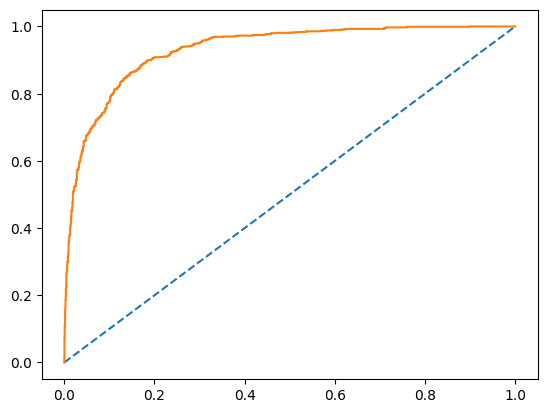

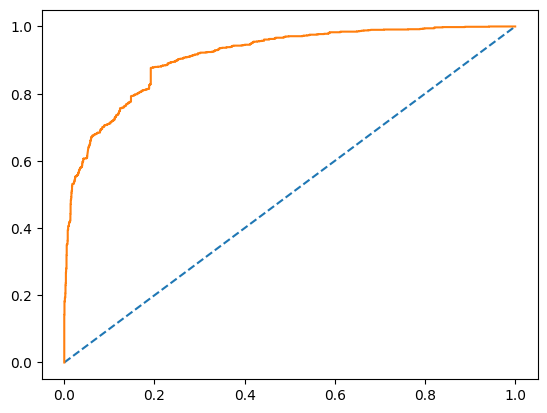

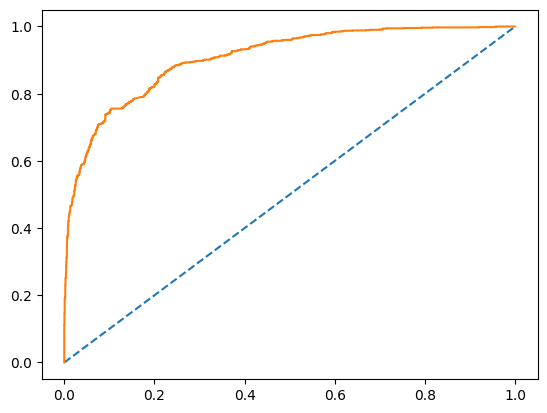

In [74]:
#Lets first encode our labels
from sklearn.preprocessing import label_binarize

y_train_lb = label_binarize(y_train_US, classes=['Negative','Neutral','Positive'])
y_test_lb = label_binarize(y_test_US, classes=['Negative','Neutral','Positive'])

n_classes = y_train_lb.shape[1]

#Create NaiveBayes OneVsRestClassifier Model
from sklearn.multiclass import OneVsRestClassifier

multiClassModel = OneVsRestClassifier(MultinomialNB())
y_score = multiClassModel.fit(X_train_bow_US.toarray(),y_train_lb).predict_proba(X_test_bow_US.toarray())

#Plot ROC-AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

fpr=dict()
tpr=dict()
auc =dict()

for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_test_lb[:,i], y_score[:,i])
    auc[i] = roc_auc_score(y_test_lb[:,i], y_score[:,i])

for i in range(n_classes):
    plt.figure()
    print('roc_auc_score:',auc[i])
    plt.plot([0,1],[0,1], linestyle = '--')
    plt.plot(fpr[i],tpr[i])

### Use of Logistic Regression with Oversampling Data

In [76]:
%%time
#Model building using LogisticRegression
from sklearn.linear_model import LogisticRegression
model_LR_OS=LogisticRegression()

model_LR_OS.fit( X_train_bow_OS,y_train_OS)

#Get Train and Test Accuracy Score
train_score=model_LR_OS.score(X_train_bow_OS,y_train_OS)
test_score=model_LR_OS.score(X_test_bow_OS,y_test_OS)
print('train score is:{} '.format(train_score))
print('test score is:{} '.format(test_score))
print()
#Get precision    recall  and f1-score on Train data
cr=classification_report(y_true=y_train_OS,y_pred=model_LR_OS.predict( X_train_bow_OS ))
print('classification_report TRAIN Data\n',cr)

#Get precision    recall  and f1-score on Test data
cr=classification_report(y_true=y_test_OS,y_pred=model_LR_OS.predict( X_test_bow_OS ))
print('classification_report TEST Data\n',cr)

train score is:0.9733896282460373 
test score is:0.8944041208147975 

classification_report TRAIN Data
               precision    recall  f1-score   support

    Negative       0.98      1.00      0.99     51396
     Neutral       0.97      0.96      0.97     51396
    Positive       0.97      0.97      0.97     51396

    accuracy                           0.97    154188
   macro avg       0.97      0.97      0.97    154188
weighted avg       0.97      0.97      0.97    154188

classification_report TEST Data
               precision    recall  f1-score   support

    Negative       0.96      0.81      0.88     12813
     Neutral       0.83      0.94      0.88     12813
    Positive       0.91      0.93      0.92     12813

    accuracy                           0.89     38439
   macro avg       0.90      0.89      0.89     38439
weighted avg       0.90      0.89      0.89     38439

CPU times: total: 6.31 s
Wall time: 14 s


In [80]:
%%time
#Lets first encode our labels
from sklearn.preprocessing import label_binarize

y_train_lb = label_binarize(y_train_OS, classes=['Negative','Neutral','Positive'])
y_test_lb = label_binarize(y_test_OS, classes=['Negative','Neutral','Positive'])

n_classes = y_train_lb.shape[1]

#Create NaiveBayes OneVsRestClassifier Model
from sklearn.multiclass import OneVsRestClassifier

multiClassModel = OneVsRestClassifier(LogisticRegression())
y_score = multiClassModel.fit(X_train_bow_OS.toarray(),y_train_lb).predict_proba(X_test_bow_OS)

#Plot ROC-AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

fpr=dict()
tpr=dict()
auc =dict()

for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_test_lb[:,i], y_score[:,i])
    auc[i] = roc_auc_score(y_test_lb[:,i], y_score[:,i])

for i in range(n_classes):
    plt.figure()
    print('roc_auc_score:',auc[i])
    plt.plot([0,1],[0,1], linestyle = '--')
    plt.plot(fpr[i],tpr[i])

MemoryError: Unable to allocate 42.2 GiB for an array with shape (154188, 36702) and data type float64

In [21]:
X_train_smote.shape

(192627, 10000)

In [22]:
y_train_smote.shape

(192627,)

In [23]:
y_train_smote.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [35]:
pd.DataFrame(X_train_smote.todense(), columns=tfidf.get_feature_names_out())

,aa,aaa,aaand,aalvarezgarcia,aampws,aapl,aaron,aaronmsaunders,aaronwoodman,ab,...,zone,zookeeper,zoomdata,zoomdatas,zoran,zos,zu,zwlf,zynga,zzp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
pd.DataFrame(X_train_smote.todense()[y_train_smote == 0], columns=tfidf.get_feature_names_out())

,aa,aaa,aaand,aalvarezgarcia,aampws,aapl,aaron,aaronmsaunders,aaronwoodman,ab,...,zone,zookeeper,zoomdata,zoomdatas,zoran,zos,zu,zwlf,zynga,zzp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
tvec = TfidfVectorizer(stop_words='english', max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              negative    neutral     positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)
   
    print("accuracy: %.2f%%" % (np.mean(accuracy)))
    print("precision: %.2f%%" % (np.mean(precision)))
    print("recall: %.2f%%" % (np.mean(recall)))
    print("f1 score: %.2f%%" % (np.mean(f1)))

In [12]:
lr_cv(5, df.clean_text_processed, df.Mood, SMOTE_pipeline, 'macro')

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              negative    neutral     positive
precision: [0.6754386  0.9588513  0.91141657]
recall:    [0.80056711 0.94899548 0.90041494]
f1 score:  [0.73269896 0.95389793 0.90588235]
--------------------------------------------------


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              negative    neutral     positive
precision: [0.67251908 0.96234441 0.92631781]
recall:    [0.8319169  0.9512537  0.90831919]
f1 score:  [0.74377374 0.95676692 0.91723021]
--------------------------------------------------


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              negative    neutral     positive
precision: [0.68298368 0.96120111 0.91311787]
recall:    [0.83002833 0.94720449 0.90605546]
f1 score:  [0.74936061 0.95415147 0.90957296]
--------------------------------------------------


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              negative    neutral     positive
precision: [0.6874028  0.95895464 0.92035569]
recall:    [0.83553875 0.95148731 0.89813243]
f1 score:  [0.75426621 0.95520638 0.90910827]
--------------------------------------------------


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              negative    neutral     positive
precision: [0.68262987 0.95990863 0.91465959]
recall:    [0.79489603 0.94906939 0.90965673]
f1 score:  [0.73449782 0.95445824 0.9121513 ]
--------------------------------------------------
accuracy: 92.99%
precision: 85.25%
recall: 89.09%
f1 score: 86.95%


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.97      0.94     12777
           0       0.94      0.92      0.93     12793
           1       0.93      0.90      0.91     12956

    accuracy                           0.93     38526
   macro avg       0.93      0.93      0.93     38526
weighted avg       0.93      0.93      0.93     38526



In [42]:
import pickle

# Save the model to a pickle file
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)